In [163]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from lesson_functions import *

import concurrent
from moviepy.editor import VideoFileClip
from lesson_functions import *
import matplotlib.pyplot as plt
import matplotlib
from scipy.ndimage.measurements import label
import pickle
from collections import OrderedDict
from os.path import join

%matplotlib inline

In [165]:
def show_images(img1, title1, img2=None, title2=None):        
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=30)    
    ax2.imshow(img2)
    ax2.set_title(title2, fontsize=30)

In [166]:
image = mpimg.imread('./test_images/test1.jpg')

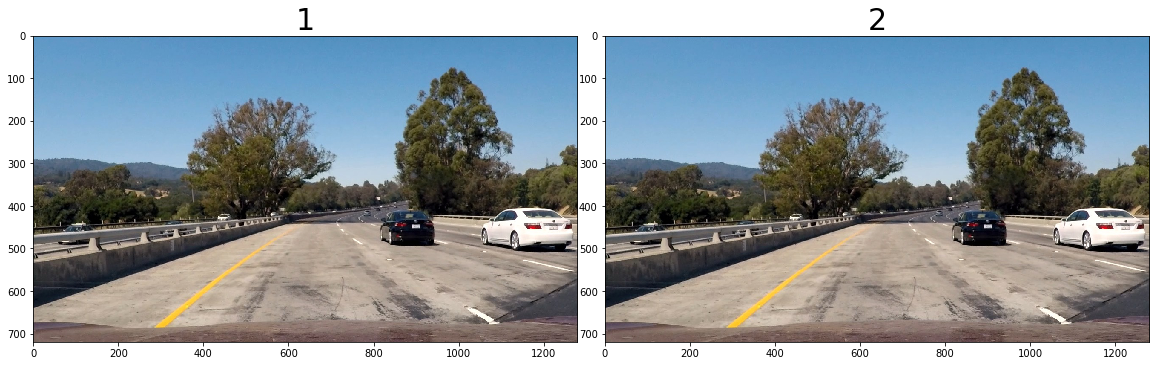

In [167]:
show_images(image, '1', image, '2')


## Deserialize Trained Model

In [168]:
file_name = "svc.p"
with open(file_name, "rb") as ifile:
    svc, X_scaler = pickle.load(ifile)

## Set Up Parameters

While a lot of the parameters were taken from lessons in the class, others came from forum discussions, and others were purely from experimentation.

In [177]:
color_space = 'HLS'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = "ALL"  # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)  # Spatial binning dimensions
hist_bins = 16  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off

## Helper Methods From Class

In [178]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=(None, None), y_start_stop=(None, None), 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop_0 = 0
    if x_start_stop[1] == None:
        x_start_stop_1 = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop_0 = 0
    if y_start_stop[1] == None:
        y_start_stop_1 = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop_1 - x_start_stop_0
    yspan = y_start_stop_1 - y_start_stop_0
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop_0
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop_0
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

windows = slide_window(image, x_start_stop=(None, None), y_start_stop=(None, None), 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))

In [101]:
# x_start_stop = (120, 1280-120)
# y_start_stop = (375, 500)

In [179]:
startx = 0
starty = 0
endx = 200
endy = 200
#boxed_img = draw_boxes(image, [((startx, starty), (endx, endy))])

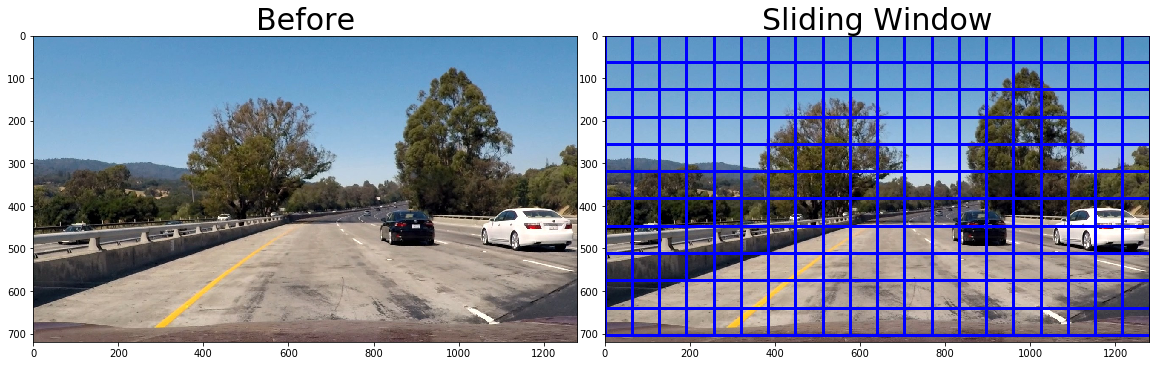

In [180]:
bi = draw_boxes(image, windows)
show_images(image, 'Before', bi, 'Sliding Window')

## Combing Sliding Window with Trained Model

Here we are combining the sliding windows with our classifier to identify boxes that are identified as having a 
vehicle in it. 

In [181]:
def run_windowing_and_detection_with_image(arg):
    xy_size, param_dict, image = arg[0], arg[1], arg[2]
    windows = slide_window_from_bottom(
        image, x_start_stop=param_dict["x_start_stop"], y_start_stop=param_dict["y_start_stop"],
        xy_window=(xy_size, xy_size), xy_overlap=param_dict["xy_overlap"])

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space,
                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                 orient=orient, pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block,
                                 hog_channel=hog_channel, spatial_feat=spatial_feat,
                                 hist_feat=hist_feat, hog_feat=hog_feat)
    return hot_windows

Combination of window sizes, x/y starts and stop, and amount of overlap. This came from a lot of experimentation, dicussion forums, and lectures.

In [182]:
window_params = OrderedDict([
    (64, {"xy_overlap": (0.75, 0.75), "x_start_stop": (120, 1280-120), "y_start_stop": (375, 500)}),
    (70, {"xy_overlap": (0.75, 0.75), "x_start_stop": (60, 1280-60), "y_start_stop": (375, 500)}),
    (90, {"xy_overlap": (0.75, 0.75), "x_start_stop": (0, 1280), "y_start_stop": (375, 560)}),
    (115, {"xy_overlap": (0.5, 0.5), "x_start_stop": (0, 1280), "y_start_stop": (375, 600)}),
    (154, {"xy_overlap": (0.5, 0.5), "x_start_stop": (0, 1280), "y_start_stop": (400, 680)}),
    (185, {"xy_overlap": (0.5, 0.5), "x_start_stop": (0, 1280), "y_start_stop": (450, 680)}),
    (218, {"xy_overlap": (0.5, 0.5), "x_start_stop": (0, 1280), "y_start_stop": (450, 680)}),
])

## Get Boxes for a Given Image Using Parmaters Above

In [107]:
def get_boxes_for_image(image, win_params):
    cnv = convert_to_float_if_required(image)

    boxes = []
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for new_boxes in executor.map(run_windowing_and_detection_with_image,
            [(k, v, cnv) for k, v in win_params.items()]):
                boxes += new_boxes
    return boxes

In [183]:
# cnv = convert_to_float_if_required(image)

# boxes = []
# with concurrent.futures.ProcessPoolExecutor() as executor:
#     for new_boxes in executor.map(run_windowing_and_detection_with_image,
#         [(k, v, cnv) for k, v in window_params.items()]):
#             boxes += new_boxes




### Test Boxes on Images

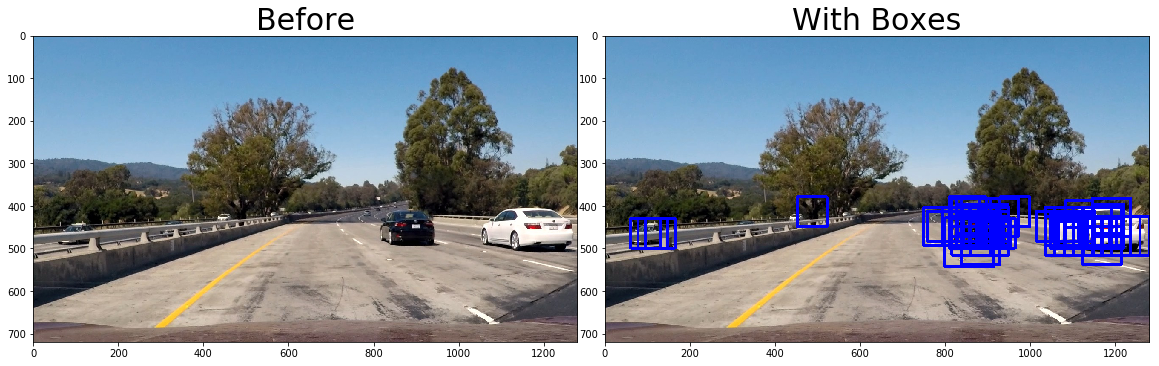

In [184]:
bi2a = get_boxes_for_image(image, window_params)
bi2 = draw_boxes(image, bi2a)
show_images(image, 'Before', bi2, 'With Boxes')

In [185]:
def test_box_images(file):
    image2 = mpimg.imread(file)
    boxes_img_2 = get_boxes_for_image(image2, window_params)
    img2_with_boxes = draw_boxes(image2, boxes_img_2)
    show_images(image2, 'Before Boxes', img2_with_boxes, 'With Boxes')

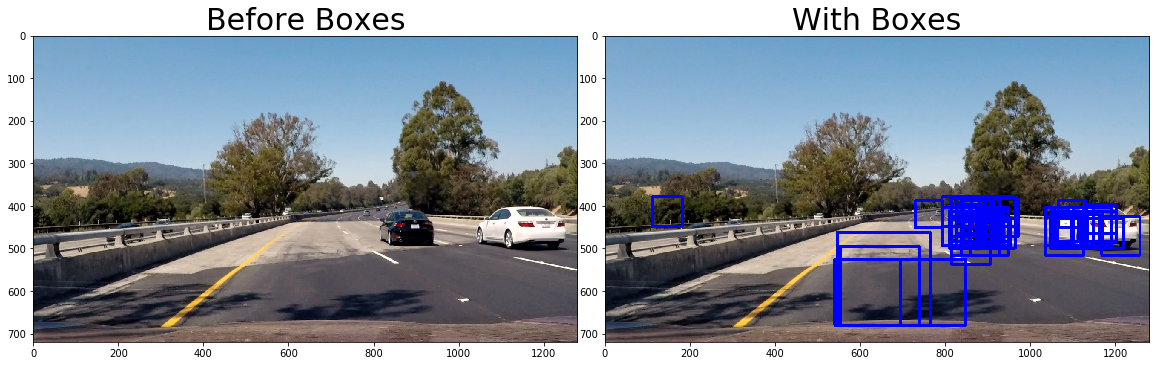

In [186]:
test_box_images('./test_images/test4.jpg')

## Code for Heatmaps

In [187]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


In [188]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


In [189]:
#box_list = get_boxes_for_image(image, window_params)
# heat = np.zeros_like(image[:,:,0]).astype(np.float)

# # Add heat to each box in box list
# heat = add_heat(heat,image_boxes)
    
# # Apply threshold to help remove false positives
# heat = apply_threshold(heat,1)

# # Visualize the heatmap when displaying    
# heatmap = np.clip(heat, 0, 255)



In [190]:
#from scipy.ndimage.measurements import label
#labels = label(heatmap)


In [191]:
from scipy.ndimage.measurements import label
box_list = get_boxes_for_image(image, window_params)

heat = np.zeros_like(image[:,:,0]).astype(np.float)
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

## Test Heatmap

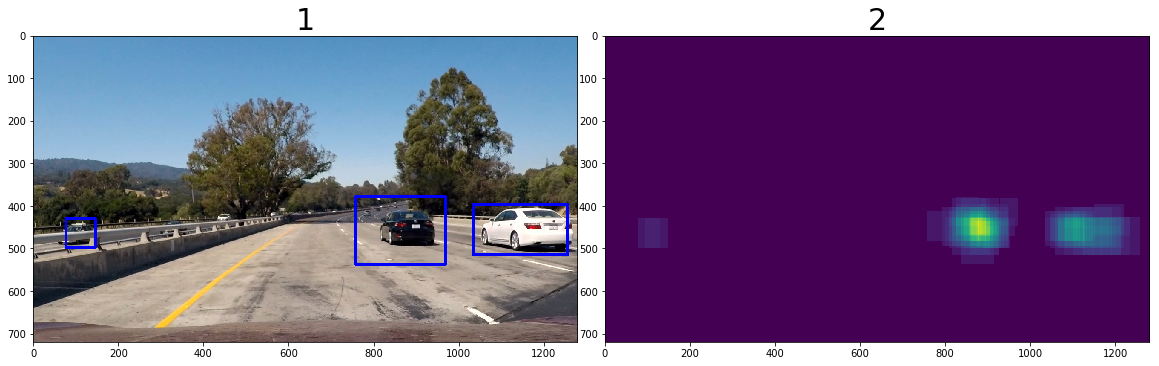

In [193]:
show_images(draw_img, '1', heatmap, '2')

In [129]:
def get_heat_labels(image, boxes, threshold=1):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # create a heat map for filtering false positives
    heat = add_heat(heat, boxes)
    heat = apply_threshold(heat, threshold)
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    img = draw_labeled_bboxes(image, labels)
    return img

In [158]:
boxes_queue = []

## Pipeline

This is the main pipeline for processing images in the video. I encountered a number of problems with getting the boxes on the images and not flashing/"jumping around" between images. The dicussion forum provided me with an approach for "smooting frames" used below with the "boxes_queue". Additionally, information for the "thesholds" was also gleaned from the discussion forums.   

In [194]:
def pipeline(img):
    
    global boxes_queue
    
    n_frames = 50
    thresh = 230
    n_smoothing_frames = 10
    
    # detect all boxes
    #cnv = convert_to_float_if_required(img)
    img_cpy = img.copy()
    boxes = get_boxes_for_image(img_cpy, window_params)  #get_boxes(cnv)
    
    boxes_queue.append(boxes)
    if len(boxes_queue) > n_smoothing_frames:
            boxes_queue = boxes_queue[-n_smoothing_frames:]
            
    queue_boxes = [box for sublist in boxes_queue for box in sublist]

    threshold = 15
    image_to_return = get_heat_labels(img_cpy, boxes, threshold)
    return image_to_return
    # add to queue, get all the ones for smoothing
    #self.add_boxes_set(boxes)
    #boxes4smoothing = self.get_all_queue_boxes()
#     boxes4smoothing = boxes

#     heat = np.zeros_like(img[:,:,0]).astype(np.float)
#     # create a heat map for filtering false positives
#     heat = add_heat(heat, boxes4smoothing)
#     heat = apply_threshold(heat, self.get_threshold())
#     heatmap = np.clip(heat, 0, 255)
#     # Find final boxes from heatmap using label function
#     labels = label(heatmap)
#     img = draw_labeled_bboxes(img, labels)

    # img = draw_boxes(img, boxes, color=(0, 0, 255), thick=4)
    #return img




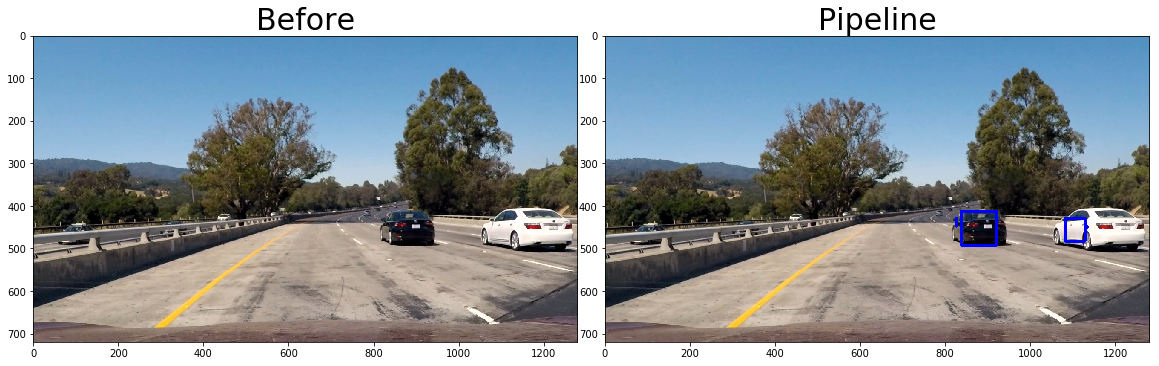

In [197]:
image_test_pipe = mpimg.imread('./test_images/test1.jpg')
result = pipeline(image_test_pipe)
show_images(image_test_pipe, 'Before', result, 'Pipeline')

In [162]:
video_name = "project_video.mp4"
output_directory = "."
out_fn = "0.0.6_frames_{}_thresh_{}_{}".format(n_frames, thresh, video_name)
clip = VideoFileClip("./" + video_name)
project_clip = clip.fl_image(pipeline)
project_clip.write_videofile(join(output_directory, out_fn), audio=False)
print("Output video: {}".format(out_fn))


[MoviePy] >>>> Building video ./test_pipepine.mp4
[MoviePy] Writing video ./test_pipepine.mp4


100%|█████████▉| 1260/1261 [27:17<00:01,  1.30s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_pipepine.mp4 

Output video: test_pipepine.mp4
